# Data Science Tutorial 02 @ Data Science Society
那須野薫(Kaoru Nasuno)/ 東京大学(The University of Tokyo)

データサイエンスの基礎的なスキルを身につける為のチュートリアルです。  
KaggleのコンペティションであるRECRUIT Challenge, Coupon Purchase Predictionのデータセットを題材として、  
データサイエンスの基礎的なスキルに触れ，理解の土台を養うことを目的とします。  
(高い予測精度を出すことが目的ではないです)  
まだ、書きかけでして、要望に合わせて誤りの修正や加筆をしていく予定です。何かお気づきの点があればご連絡頂けますと幸いです。

## 対象データ
RECRUIT Challenge, Coupon Purchase Predictionのデータセット。  
ユーザ登録や利用規約に同意してダウンロードしてください。  
https://www.kaggle.com/c/coupon-purchase-prediction/data

## 進め方
Lecture01をやっていない方はLecture01を先にやってください。  
まずは、全てのコードをコピー&ペーストして、エラーなく動作することを確認しましょう。  
この段階でエラーが出る場合には環境が整っていないか、パラメタの設定ができていない等、  
プログラムの理解とはあまり関係のない箇所が原因である可能性が高いです。  
動作確認が終わったら、ひとつずつ書き写してみて、それぞれどのように動作するかを理解していくという方法をお勧めします。  



## 目次
1. 下準備
2. データベースへのデータの展開
3. <span style="color: #FF0000;">モデリング対象の明確化</span>
4. <span style="color: #FF0000;">機械学習による予測モデルの構築・精度検証</span>
5. <span style="color: #FF0000;">データの概観把握・予測モデルの改善</span>



In [2]:
# TODO: You Must Change the setting bellow
MYSQL = {
    'user': 'root',
    'passwd': '',
    'db': 'coupon_purchase',
    'host': '127.0.0.1',
    'port': 3306,
    'local_infile': True,
    'charset': 'utf8',
}
DATA_DIR = '/home/nasuno/recruit_kaggle_datasets'  #  ディレクトリの名前に日本語(マルチバイト文字)は使わないでください。
OUTPUTS_DIR = '/home/nasuno/recruit_kaggle/outputs'  # 予測結果などを保存するディレクトリ。

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import MySQLdb
import numpy

from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta
from itertools import product

# Random Seed
rng = numpy.random.RandomState(1234)

dbcon = MySQLdb.connect(**MYSQL)
dbcur = dbcon.cursor()


## 3. モデリング対象の設定

### 対象の明確化
このコンペティションの最終的なゴールは、各ユーザが将来どのクーポンを購入するかをより正確に予測することです。  
モデリング(≒予測モデルの構築)は
- ユーザの属性データ(性別、年代、地域など)  
- クーポンの属性データ(ジャンル、価格、地域など)  
- いつどのユーザがどのクーポンを見たか、購買したか等のログデータ  

の3つのデータを主に利用します（これは、クーポンに限らず他の多くの問題で共通しています)。  
これらのデータを利用して将来ユーザがどのクーポンを購買するのかをモデリングするわけですが、  
特に、このコンペティションでは、モデリングの良し悪しを評価する指標が与えられており、  
参加者はこの指標のスコアを競っている形になっています。  

https://www.kaggle.com/c/coupon-purchase-prediction/details/evaluation によれば、  
このコンペティションでは、Mean Average Precision@10(MAP@10)という指標を最大化するような予測モデルを構築することが最終的なゴールです。  
Map@10は、下記の数式で定義されています。
$$
MAP@10=\frac{1}{|U|}\sum_{u=1}^{|U|}\frac{1}{min(m, 10)} \sum_{k=1}^{min(n, 10)}P(k)
$$
$|U|$：ユーザ数  
$P(k)$：k番目まで着目した時のPrecision(購買すると予測したクーポン中の実際に購買されたクーポンの割合)  
$n$：購買すると予測されたクーポンの数  
$m$：実際に購買されたクーポンの数(m=0の時は、Precision=0)

この指標を直接最大化するようにモデリングする方がコンペティションの最終的な評価は高いと考えられますが、  
ここでは、簡単のため、下記のように問題を少し変更し別の指標で代替することにします。  
- 全てのユーザは検証用の期間で必ずクーポンをちょうど1つ購入する。  
- その1つのクーポンを訓練用の期間のデータから予測する。  

このように問題を簡単にし、検証用の期間で購買される確率が最も高いクーポンを選択する問題にすることで、  
正解率(Accuracy)でモデルの良し悪しを近似的に評価することが出来ます。  
このように、近似した問題に対してモデルを構築することとして、以下は進めていきます。

### モデル構築に於ける3つのデータ：training data, validation data, test data  

データはまず大きく分けて、訓練用のデータとテスト用のデータ(test data)に大別されます。  
特に、Kaggleのコンペティションのデータセットは明示的にそれらが分けられているものもあります。  
通常、訓練用のデータで予測モデルを構築し、テスト用のデータで構築した予測モデルの精度を検証します。

<img src="files/data_split.png" width="600px;"/>


このチュートリアルでは、機械学習のアルゴリズムに基づいた予測モデルを構築しますが、  
機械学習のアルゴリズムには一般にハイパーパラメタというものが存在します。  
機械学習アルゴリズムには、内部パラメタとハイパーパラメタの2つのパラメタがあり、  
内部パラメタは自動で学習しますが、ハイパーパラメタは予め設定する必要があります。  
良い精度を出すためにはハイパーパラメタをこのうまく調整する必要があります。   


実際に予測モデルを構築する際には、訓練用のデータをさらにtraining dataとvalidation dataに分けて、  
あるハイパーパラメタでtraining dataから予測モデルを構築しvalidation dataで精度を検証し、  
別のハイパーパラメタで予測モデルを構築しvalidation dataで精度を検証し、、、  
ということを繰り返します。

最終的な精度評価に際しては、  
validation dataへの検証実験で良い結果となったハイパーパラメタで構築された予測モデルを今度はtest dataに適用し、  
実際に未知のデータに対して、どれくらいの精度で予測できるのかということ検証します。

ここでは、便宜的に訓練データの最後の1週間の期間(2012-06-17 00:00:00から2012-06-23 23:59:59)をvalidation dataとし、  
残りの約1年の期間をtraining dataとして、データを分割します。

In [4]:
validation_start = datetime.strptime('2012-06-17 00:00:00', '%Y-%m-%d %H:%M:%S')
validation_end = validation_start + timedelta(days=7)
dbcur.execute(''' DROP TABLE IF EXISTS coupon_visit_train_training;''')  # チュートリアルの便宜上一回削除します。
dbcur.execute(''' CREATE TABLE IF NOT EXISTS coupon_visit_train_training LIKE coupon_visit_train;''')
dbcur.execute('''
    INSERT INTO coupon_visit_train_training
        SELECT * 
        FROM coupon_visit_train
        WHERE i_date >= "2011-07-01 00:00:00" AND i_date < %s
    ;
''', (validation_start, ))

dbcur.execute(''' DROP TABLE IF EXISTS coupon_visit_train_validation;''')  # チュートリアルの便宜上一回削除します。
dbcur.execute(''' CREATE TABLE IF NOT EXISTS coupon_visit_train_validation LIKE coupon_visit_train;''')
dbcur.execute('''
    INSERT INTO coupon_visit_train_validation
        SELECT * 
        FROM coupon_visit_train
        WHERE i_date >= %s
    ;
''', (validation_start, ))


65468L

### ランダム推定・MAP@10の評価
先にも触れましたが、本コンペティションではMAP@10というスコアを競い合っています。  
提出のフォーマットは、https://www.kaggle.com/c/coupon-purchase-prediction/details/evaluation に  
記載されています。

訓練データをtraining dataと validation dataに分割したので、  
試しに、各ユーザが購買するクーポンをランダムに推定して、  
・MAP@10の性質  
・ランダム推定の精度  
・サブミッションの形式  
をざっくり把握していきましょう。

1. validation期間に購買されうるクーポンを抽出する。  
2. 抽出したクーポン群から各ユーザが購買するクーポンをランダムに10個選び、予測結果とする。  
3. 実際に購買したクーポンと照らし合わせ、MAP@10を算出する。  
4. サブミッション用のcsvファイルを作成する。  

の4ステップで見ていきます。

#### 1. validation期間に購買されうるクーポンを抽出する。  

In [5]:
# validation 期間に購買されうるクーポンの抽出
dbcur.execute('''
    SELECT
        coupon_id_hash
        FROM coupon_list_train
        WHERE
            NOT (dispend <= %s OR dispfrom > %s)
    ;
''', (validation_start, validation_end))
coupon_ids = []
for row in dbcur.fetchall():
    coupon_ids.append(row[0])

#### 2. 抽出したクーポン群から各ユーザが購買するクーポンをランダムに10個選び、予測結果とする。  


In [6]:
# user_idsをselectして、ランダムに、購買アイテムを割り当てる。
dbcur.execute('''
    SELECT
        user_id_hash
        FROM user_list
    ;
''')
user_pcoupon_pred = {}
for row in dbcur.fetchall():
    user_pcoupon_pred[row[0]] =list(shuffle(coupon_ids, random_state=rng)[:10])

#### 3. 実際に購買したクーポンと照らし合わせ、MAP@10を算出する。  


In [7]:
#  validation期間に購買したクーポンリストを抽出。
dbcur.execute('''
    SELECT
        user_id_hash, view_coupon_id_hash
        FROM coupon_visit_train_validation
        WHERE purchase_flg = 1
    ;
''')
user_pcoupon_true = {}
for row in dbcur.fetchall():
    if row[0] not in user_pcoupon_true:
        user_pcoupon_true[row[0]] = []
    user_pcoupon_true[row[0]].append(row[1])


#  ap10を算出する関数を定義。
def get_ap10(y_pred, y_true):
    ap10 = 0.
    y_true = set(y_true)
    for i in range(len(y_pred)):
        if y_pred[i] in y_true:
            c = set(y_pred[:i + 1])
            ap10 += len(y_true & c) / float(i + 1)
    ap10 /= min(len(y_true), 10)
    return ap10

map10 = 0.
n_purchased_user = 0.
for user_id in user_pcoupon_pred:
    if user_id not in user_pcoupon_true:
        # 当該ユーザがvalidation期間にcouponを買わなかった場合、
        # ap@10は0 
        continue
    n_purchased_user += 1
    y_true = user_pcoupon_true[user_id]
    y_pred = user_pcoupon_pred[user_id]
    
    map10 += get_ap10(y_pred, y_true)

max_map10 = n_purchased_user / len(user_pcoupon_pred)
map10 /= len(user_pcoupon_pred)

print 'max_map@10: %.5f, map@10: %.5f' % (max_map10, map10)

max_map@10: 0.08438, map@10: 0.00038


ランダムだと、全然当たらないですね。  
map@10は期間中に何人のユーザが購買しているかによって、最大値が大きく変わります。  
従って、一概に他の期間と比較することは出来ませんが、執筆時点で最も高いスコアでも0.01よりも少し多き程度のスコアなので、  
スコア自体はまだまだ改善の余地があると考えられます。  
※実際にスコアを上げる(=高い精度で予測できるようにする)のは、非常に大変です。

#### 4. サブミッション用のcsvファイルを作成する。


In [8]:
output = ['USER_ID_hash,PURCHASED_COUPONS']
for user_id in user_pcoupon_pred:
    output.append(user_id + ',' + ' '.join(user_pcoupon_pred[user_id]))

output = '\n'.join(output)
with open(OUTPUTS_DIR + '/random_prediction_valid.csv', 'wb') as fid:
    fid.write(output)


### Excercise
test dataに対して、同様の手法で予測・csvに結果を出力して、  
コンペティションにサブミットしてください。  
※1日に最大5回までしかサブミットできないので、注意してください。


## 4. 機械学習アルゴリズムによる予測モデルの構築
先の章では、モデリング対象や評価指標への理解を深めました。  
具体的に先に挙げた、  
- ユーザの属性データ(性別、年代、地域など)  
- クーポンの属性データ(ジャンル、価格、地域など)  
- いつどのユーザがどのクーポンを見たか、購買したか等のログデータ  

のそれぞれの要素がどれぐらい将来の購買行動と関連があるのか、  
を考える前に、まず簡単に機械学習アルゴリズムによる予測モデルを構築して、  
アルゴリズムの内部がどうなっているのか、  
アルゴリズムのinputとoutputがどうなっているのか、  
見ていきましょう。  

ここでは、下記の設定、  
対象アルゴリズム：ロジスティック回帰  
対象データ：ユーザの属性データとクーポンの属性データ  
将来購買されるクーポンを予測するということをやってみましょう。

### 機械学習アルゴリズム
ロジスティック回帰は非常にシンプルなアルゴリズムで
下記の数式のように定義されています。
$$
v=Wx+b  
$$
$$
y \simeq \tilde{y}=\frac{exp(v)}{\sum_{k=1}^{N}exp(v_k)}  
$$

$x$：素性ベクトル(ユーザとクーポンの特徴を表現したベクトル)  
$W$：素性ベクトルの各列をどれだけ評価するかのウェイトマトリックス(パラメタ)  
$b$：バイアス項(パラメタ)  
$N$：クラスの数(この場合、買われたか否か)  
$v$：N次元ベクトル  
$\tilde{y}$：各クラスが発生する確率  
$y$：正解ベクトル  

ロジスティック回帰は与えられた素性ベクトル$x$の各次元の重みを評価して、各クラスに所属する確率$\tilde{y}$を算出します。  
モデルの学習の際には、$\tilde{y}$と$y$の誤差が最小となるように内部のパラメタ$W$と$b$を学習し、  
予測の際には、入力$x$を計算式に当てはめ、出力結果$\tilde{y}$を見て、例えば、所属する確率が最大のクラスを予測結果とします。  
つまり、学習の際は入力は$x$と$y$で、予測の際は入力は$x$のみです。  
これは、他の多くの機械学習アルゴリズムに共通です。  
機械学習ライブラリの1つであるscikit-learnは、  
多くの機械学習アルゴリズムに対して共通のフレームワークで提供され内部がブラックボックス化されており、  
中身が分からなくても簡単に利用できるものとなっています。  
ここでは、scikit-learnで提供されているロジスティック回帰を利用していきます。  

### データ加工(素性/ラベル作成)
簡単のためログデータを用いずに、  
ユーザの属性データとクーポンの属性データのみを用いて素性$x$を作成します。  

特徴ベクトルを作成する際には、
1. 各次元のスケールを合わせる  
2. 連続値で表現すべきでないところは、フラグにする  

を意識しましょう。

#### ユーザの特徴ベクトル
sequel proでuser_listテーブルを見てみると、  
素性に利用しやすそうな属性として、性別、年齢、場所があります。  
性別と場所は連続値でないため、フラグで表現します。  
年齢のような連続値は、場合によってはフラグとした方が良い時もありますが、  
ここでは、連続値として扱います。  
sequel proで年齢のカラムをソートしてみると、  
最小値が15最大値が80なので素性を作る時はスケールを合わせるために、  
年齢値から15引いて65で割ります。  
このように、[0, 1]の値での表現のように最小値と最大値を整えるスケーリングをmini max scaling等と呼びます。  
他には平均0分散1の標準正規分布に変換するstandard scalingがあります。  
※いずれもscikit-learnのpreprocessingモジュール(http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing )に実装されています。  


In [9]:
# ユニークな都道府県リストの取得
dbcur.execute(''' SELECT pref_name FROM prefecture_locations ORDER BY pref_name ; ''')
pref_data = []
for row in dbcur.fetchall():
    pref_data.append(row)

# ユーザの素性を作成。(ユーザの素性はtraining、validation, testで共通)
dbcur.execute('''
    SELECT
        t1.user_id_hash,
        IF(t1.sex_id = 'm', 1, 0),
        (t1.age-15)/65,
        ''' + ', '.join([u'IF(t1.pref_name = "' + p[0] + u'", 1, 0)' for i, p in enumerate(pref_data)]) + '''
    FROM user_list AS t1
''')

user_feature = {}  # ユーザの素性ベクトル
for row in dbcur.fetchall():
    user_feature[row[0]] = row[1:]


#### クーポンの特徴ベクトル
アイテムは、比較的用意に利用できそうなフラグのカラムが多いです。  
ここでは、簡単のためフラグのみを、  
学習に利用するクーポンはvalidation期間の前の7日で購買可能なデータ  
を利用して特徴ベクトルを作っていきます。  
※実際には、より多くのデータを使った方が精度は出る傾向にあります。

In [10]:
training_start = validation_start - timedelta(days=7)  # 訓練開始日時を算出。

# カテゴリリストの取得
dbcur.execute(''' SELECT DISTINCT(capsule_text) FROM coupon_list_train ORDER BY capsule_text;''')
capsule_data = []
for row in dbcur.fetchall():
    capsule_data.append(row)

# ジャンルリストの取得
dbcur.execute(''' SELECT DISTINCT(genre_name) FROM coupon_list_train ORDER BY genre_name;''')
genre_data = []
for row in dbcur.fetchall():
    genre_data.append(row)

# 大エリアリストの取得
dbcur.execute(''' SELECT DISTINCT(large_area_name) FROM coupon_list_train ORDER BY large_area_name;''')
larea_data = []
for row in dbcur.fetchall():
    larea_data.append(row)

# 都道府県リストの取得
dbcur.execute(''' SELECT DISTINCT(ken_name) FROM coupon_list_train ORDER BY ken_name;''')
pref_data = []
for row in dbcur.fetchall():
    pref_data.append(row)

# 小エリアリストの取得
dbcur.execute(''' SELECT DISTINCT(small_area_name) FROM coupon_list_train ORDER BY small_area_name;''')
sarea_data = []
for row in dbcur.fetchall():
    sarea_data.append(row)

def get_item_feature(f_date, t_date):
    #  クーポンの素性を作成する関数。
    # @f_date：対象期間の開始日時
    # @t_date：対象期間の終了日時
    # テーブルが訓練用のテーブルとなっている為、training とvalidationのデータを作成する際にしか利用できない。
    dbcur.execute('''
        SELECT
            coupon_id_hash,
            ''' + ', '.join([u'IF(capsule_text = "' + p[0] + u'", 1, 0)' for i, p in enumerate(capsule_data)]) + ''',
            ''' + ', '.join([u'IF(genre_name = "' + p[0] + u'", 1, 0)' for i, p in enumerate(genre_data)]) + ''',
            COALESCE(CAST(usable_date_mon AS SIGNED), 0),
            COALESCE(CAST(usable_date_tue AS SIGNED), 0),
            COALESCE(CAST(usable_date_wed AS SIGNED), 0),
            COALESCE(CAST(usable_date_thu AS SIGNED), 0),
            COALESCE(CAST(usable_date_fri AS SIGNED), 0),
            COALESCE(CAST(usable_date_sat AS SIGNED), 0),
            COALESCE(CAST(usable_date_sun AS SIGNED), 0),
            COALESCE(CAST(usable_date_holiday AS SIGNED), 0),
            COALESCE(CAST(usable_date_before_holiday AS SIGNED), 0),
            ''' + ', '.join([u'IF(large_area_name = "' + p[0] + u'", 1, 0)' for i, p in enumerate(larea_data)]) + ''',
            ''' + ', '.join([u'IF(ken_name = "' + p[0] + u'", 1, 0)' for i, p in enumerate(pref_data)]) + ''',
            ''' + ', '.join([u'IF(small_area_name = "' + p[0] + u'", 1, 0)' for i, p in enumerate(sarea_data)]) + '''

        FROM coupon_list_train
        WHERE
            NOT (dispend <= %s OR dispfrom > %s)
        ;
    ''', (f_date, t_date))
    item_feature = {} # クーポンの素性
    for row in dbcur.fetchall():
        item_feature[row[0]] = row[1:]
        
    return item_feature

item_feature_train = get_item_feature(training_start, validation_start)  # training 期間のクーポンの素性
item_feature_valid = get_item_feature(validation_start, validation_end) # validation 期間のクーポンの素性
print 'n_item_train: %d, n_item_valid: %d' % (len(item_feature_train), len(item_feature_valid))

n_item_train: 576, n_item_valid: 665


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:60: Warning: Truncated incorrect INTEGER value: 'NA'


#### ユーザ・クーポンの特徴ベクトルと正解ラベルの割当
ユーザ特徴ベクトルとクーポン特徴ベウトルの関係性を評価する方法は無数にあります。  
ベクトルを横に結合するという単純な方法や、  
単純な結合に加えてそれぞれの掛け合わせも加えるという方法(pair-wise)、  
などが代表的な簡単な方法です。  
素性が長くなれば、それだけ情報量が多くなりますが、一方で過学習(Over fitting)が起きやすくなります。  
「過学習が起きる」とは、訓練データでモデルを学習させる際に、過剰に訓練データにフィッティングして、  
validationデータやtest dataに対する汎化性能が低いモデルが出来てしまう現象で、  
本来、未知のデータに対する汎化・予測性能のあるモデルを構築したいため、  
過学習を防ぐ必要があります。  
しかし、過学習を防ぐプロセスはやや煩雑であるため、  
ここでは意識せず、単にベクトルを横に結合するという方法ですすめます。



In [11]:
def get_purchased_coupons(f_date, t_date):
    # 実際に購買されるクーポンの取得
    # @f_date：対象期間の開始日時
    # @t_date：対象期間の終了日時
    dbcur.execute('''
        SELECT user_id_hash, view_coupon_id_hash 
        FROM coupon_visit_train
        WHERE i_date >= %s AND i_date < %s AND purchase_flg = 1
        ORDER BY user_id_hash, view_coupon_id_hash
        ;
    ''', (f_date, t_date))

    purchased_items = {}  # 各ユーザがどのクーポン群を購入するかを辞書型で返す。
    for row in dbcur.fetchall():
        if row[0] not in purchased_items:
            purchased_items[row[0]] = set([])
        purchased_items[row[0]].add(row[1])

    return purchased_items

user_pcoupon_train = get_purchased_coupons(training_start, validation_start)  # training 期間に各ユーザが実際に買ったクーポン
user_pcoupon_valid = get_purchased_coupons(validation_start, validation_end)  # validation 期間に各ユーザが実際に買ったクーポン


In [12]:
n_pairs_train = len(user_feature) * len(item_feature_train)  # ユーザ数×trainingクーポン数
n_pairs_valid = len(user_feature) * len(item_feature_valid)  # ユーザ数×validation クーポン数
print 'n_train_datasets: %d, n_validation_datasets: %d, n_puser: %d' %(n_pairs_train, n_pairs_valid, len([1 for a in user_pcoupon_train if len(a) > 0]))


n_train_datasets: 13174848, n_validation_datasets: 15210545, n_puser: 1419


全部のペアを考慮すると1000万行程度となってしまいメモリに乗り切らなさそうです。  
購買していないユーザは訓練データから外してしまいましょう。  
また、validation dataのペアも逐次的に生成するようにした方が良さそうなので、そのように進めます。


In [14]:
# 訓練データに利用するユーザをtraining期間に、実際にクーポンを購入したユーザに限定し、そのユーザIDとクーポンのIDの全組み合せを出力する。
pairs_train = list(product([k for k in user_pcoupon_train if len(user_pcoupon_train[k]) > 0], item_feature_train.keys()))
print 'n_train_datasets: %d' %(len(pairs_train), )

features_train = []  # 学習に用いる素性
labels_train = []  # 学習に用いるラベル
for pair in pairs_train:  # 各ユーザ、アイテムペアについて
    user_id, item_id = pair
    features_train.append(user_feature[user_id] + item_feature_train[item_id])  # 単純な結合
    if user_id in user_pcoupon_train and item_id in user_pcoupon_train[user_id]:
        #  購買された
        labels_train.append(1)
    else:
        #  購買されなかった
        labels_train.append(0)

n_train_datasets: 817344


### 予測モデルの構築・精度評価
いよいよ、機械学習アルゴリズムによる予測モデルの構築です。  
といっても、これ自体はライブラリでブラックボックス化されているため、
ここまでくれば、非常に簡単に実装できます。


In [15]:
model = LogisticRegression()  # ロジスティック回帰のモデル構築(ハイパーパラメタの調整は省略)。インスタンス化。
model.fit(features_train, labels_train)  #  x, y~を入力して学習

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [16]:
purchase_index = numpy.argmax(model.classes_)  # 1(=購買ラベル)がついている方のカラムインデックスを取得
item_index_to_item_id = sorted(item_feature_valid.keys())  #  クーポンの番号をクーポンIDに変換する。
map10 = 0.
for user_id in user_feature:  # map@10はユーザごとにap@10を算出する。
    if user_id not in user_pcoupon_valid:  # 購入したクーポンが亡ければ、ap@10は0なので、スコア評価時には飛ばす。
        continue
    feature = []
    for item_id in item_index_to_item_id:
        feature.append(user_feature[user_id] + item_feature_valid[item_id])  # 単純にユーザ素性とクーポン素性を結合
    y_proba = model.predict_proba(feature)  # 各クーポンの購買確率を算出
    y_pred_indices = numpy.argsort(y_proba[:, purchase_index])[-10:][::-1]  # 購入確率が高いクーポン上位10個のクーポン番号を取得
    y_pred_item_ids = [item_index_to_item_id[i] for i in y_pred_indices]  # クーポン番号をクーポンIDに変換。
    map10 += get_ap10(y_pred_item_ids, user_pcoupon_valid[user_id])  # ap@10を計算して、map@10に足す。
    

map10 /= len(user_feature)  # map@10はユーザ平均なので、全ユーザで割る。
print 'MAP@10: %.5f' % (map10, )


MAP@10: 0.00177


先ほどの、ランダム予測よりだいぶ上がったようです。  
今回の例では、ユーザの特徴とクーポンの特徴を単純に結合しましたが、  
モデルの入力である素性は無数の形式が存在します。  
機械学習アルゴリズムを利用する際、この素性を如何に設計するかは非常に重要です。  
他に予測精度をあげるポイントとして、  
・機械学習アルゴリズムを選ぶ。  
・機械学習アルゴリズムのハイパーパラメタを調整する。  
・前処理をちゃんとやる。  
・目的関数を正しく選ぶ。  
などがあります。  
興味がある方は、適用を検討してみてください。  


### Excercise
1. 同様の方法を test dataに適用、各ユーザの購買クーポンを予測し、submissionしてみてください。
2. 学習に用いるデータ期間を7日から増やして、精度の変化を見てみてください。



## 5. データの概観把握・予測モデルの改善
TODO: もっと多くの実例を取り上げる。

このコンペティションの最終的なゴールは、各ユーザが将来どのクーポンを購入するかを予測することです。  
先のように、ランダムに選ぶよりは、ユーザやクーポンの特徴をモデリングした方が将来の購買するクーポンを予測しやすいことが分かりました。
では、将来ユーザがどのクーポンを購入するかは、何と関係があるでしょうか。  
その関係性を捉えることで、モデリングの際によりよい結果が得られることが多いです。  

下記の2ステップで、購買確率の予測に寄与する指標が何かを探していきます。
1. 重要のデータの量やラベルの種類を確認するために、集計&可視化する。
2. 関係性についての仮説をたてる。
3. 仮説を検証するために、データを集計&可視化する。

### 重要のデータの量やラベルの種類の確認
ログデータが少ないユーザの数の確認。  
TODO：coldstart問題について加筆。  
TODO：GROUP BYの説明とこの集計の仕組みの説明の加筆。

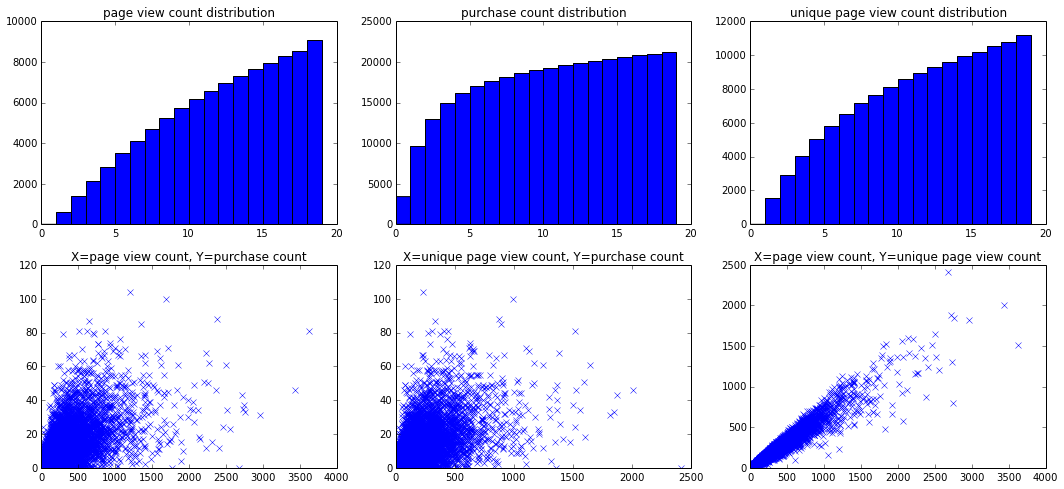

In [17]:
dbcur.execute('''
    SELECT
        COUNT(*),
        SUM(purchase_flg),
        COUNT(DISTINCT(view_coupon_id_hash))
    FROM
        coupon_visit_train
    GROUP BY user_id_hash
    ;
''')
n_view = []
n_purchase = []
n_view_u = []

for row in dbcur.fetchall():
    n_view.append(int(row[0]))
    n_purchase.append(int(row[1]))
    n_view_u.append(int(row[2]))

n_view = numpy.asarray(n_view)
n_purchase = numpy.asarray(n_purchase)
n_view_u = numpy.asarray(n_view_u)

### user-coldstartがどういった状況か見る為に、最初の20件だけ見る。
span = 20
fig = plt.figure(figsize=(18, 8))
ax = fig.add_subplot(2, 3, 1)
ax.hist(n_view, bins=numpy.arange(0, span), cumulative=True)
ax.set_title('page view count distribution')

ax = fig.add_subplot(2, 3, 2)
ax.hist(n_purchase, bins=numpy.arange(0, span), cumulative=True)
ax.set_title('purchase count distribution')

ax = fig.add_subplot(2, 3, 3)
ax.hist(n_view_u, bins=numpy.arange(0, span), cumulative=True)
ax.set_title('unique page view count distribution')

ax = fig.add_subplot(2, 3, 4)
ax.plot(n_view, n_purchase, 'x')
ax.set_title('X=page view count, Y=purchase count')

ax = fig.add_subplot(2, 3, 5)
ax.plot(n_view_u, n_purchase, 'x')
ax.set_title('X=unique page view count, Y=purchase count')

ax = fig.add_subplot(2, 3, 6)
ax.plot(n_view, n_view_u, 'x')
ax.set_title('X=page view count, Y=unique page view count')

plt.show()

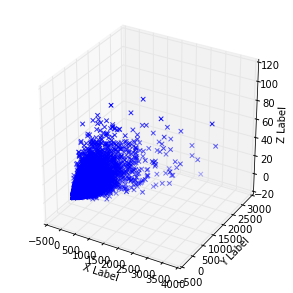

In [18]:
## 3Dにしても良く分からないことが多いので，辞めましょう。
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(n_view, n_view_u, n_purchase, marker='x')
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

最終的な精度評価に用いるテストデータに含まれる各クーポンに対して、どれくらいviewやpurchaseのデータが存在するか、の確認。  
ほとんどのクーポンでviewデータがなく、また、全てのクーポンでpurchaseのデータが存在しないitem-cold start状態なので、  
協調フィルタリングやその派生の手法は不向きであると考えられます。

In [ ]:
dbcur.execute('''
    SELECT
        t1.coupon_id_hash, COUNT(t2.view_coupon_id_hash), COALESCE(SUM(t2.purchase_flg), 0)
    FROM coupon_list_test AS t1
    LEFT JOIN coupon_visit_train AS t2 ON t1.coupon_id_hash = t2.view_coupon_id_hash
    GROUP BY t1.coupon_id_hash
    ORDER BY SUM(t2.purchase_flg)
    ;
''')
view_count = []
purchase_count = []
for row in dbcur.fetchall():
    view_count.append(int(row[1]))
    purchase_count.append(int(row[2]))

view_count = numpy.asarray(view_count)
purchase_count = numpy.asarray(purchase_count)
plt.figure()
plt.plot(purchase_count, view_count, '.')
plt.show()


### 関係性についての仮説をたてる
どういったユーザがどういったクーポンを購買するかについての仮説を立てます。  
今回のデータセットでは、例えば、下記のような仮説が立てられます。
1. ユーザは自分の地域と同じ地域を対象とするクーポンを購買する可能性が高い。 
2. ユーザは女性の方が男性より割引率の高いクーポンを購買する可能性が高い。  
3. ユーザは最後に購買したクーポンと同じジャンルのクーポンを、将来購買する可能性が高い。
4. (過去に購買したクーポンがない)ユーザは最後に閲覧したクーポンと同じジャンルのクーポンを、将来購買する可能性が高い。  


仮説を立てる際に意識して頂きたいことは、  
立てた仮説がどういったユーザがどういったクーポンを購買するかを具体的に表現していて、  
そこから、どのようにデータを集計し、検証を行うかが具体的に分かるレベルで考えるということです。  
たとえば、  
「ユーザは過去の行動に応じて、将来に購買するクーポンを変える可能性が高い。」  
という仮説をたてたとしましょう。しかし、この抽象度では具体的に何をすべきか分かりません。  
従って、正しいかもしれないが、次のアクションに繋がらないという点で、役に立たない(≒価値がない)仮説だと言えます。  
また、別の角度から見ると、立てた仮説はグレーであればあるほど、白黒はっきりさせた(検証した)あとの有用性が大きいことが多いです。

実際に、「データを分析する」際には、この「仮説を立てて、重要なところから取りかかる」ということが非常に重要です。  
スキルは所詮スキルでしかなく、使いどころを誤るといたずらに時間を溶かす結果になりますので、是非意識してもらえればと思います。



### 仮説を検証するために、データを集計&可視化する

具体例として挙げた仮説を一つずつ検証いていきましょう。  
#### 1. ユーザは自分の地域と同じ地域を対象とするクーポンを購買する可能性が高い。 
この仮説は、時間軸とは関係のなく、いわゆる**分析**的な集計である為、ここでは訓練データ全体で集計します。

In [ ]:
dbcur.execute('''
    SELECT
        AVG(same_pref_purchase_cnt),
        AVG(same_pref_view_cnt),
        AVG(same_pref_purchase_cnt / same_pref_view_cnt),
        AVG(diff_pref_purchase_cnt),
        AVG(diff_pref_view_cnt),
        AVG(diff_pref_purchase_cnt / diff_pref_view_cnt)
    FROM (
        SELECT
            t1.user_id_hash,
            SUM(t1.pref_name = t3.ken_name AND purchase_flg = 1) AS same_pref_purchase_cnt,
            SUM(t1.pref_name = t3.ken_name) AS same_pref_view_cnt,
            SUM(t1.pref_name != t3.ken_name AND purchase_flg = 1) AS diff_pref_purchase_cnt,
            SUM(t1.pref_name != t3.ken_name) AS diff_pref_view_cnt
        FROM user_list AS t1
        LEFT JOIN coupon_visit_train AS t2 ON t1.user_id_hash = t2.user_id_hash
        LEFT JOIN coupon_list_train AS t3 ON t2.view_coupon_id_hash = t3.coupon_id_hash
        WHERE t1.pref_name != ""
        GROUP BY t1.user_id_hash
    ) AS t1

    ;
''')
data = None
for row in dbcur.fetchall():
    data = row
print 'same_purchase: %.2f, same_view: %.2f, same_rate: %.2f, diff_purchase: %.2f, diff_view: %.2f, diff_rate: %.2f' % (data)

まず、同じ地域からの購買よりも，異なる地域からの購買の方が多いことが分かります。  
また、same_rateとdiff_rateを比べると、同じ地域での閲覧に於ける購買の割合より、異なる地域での閲覧に於ける購買の割合の方がやや大きいことが分かります。  
そもそも、異なる地域での閲覧が多いということ自体が先の仮定で意識したものとは異なっていた、ということもありますが、
検証したかった仮説はどうやら、正しくなさそうです。

#### 2. ユーザは女性の方が男性より割引率の高いクーポンを購買する可能性が高い。
この仮説も、時間軸とは関係のなく、いわゆる**分析**的な集計である為、ここでは訓練データ全体で集計します。

In [ ]:
dbcur.execute('''
    SELECT
        t1.sex_id,
        AVG(t1.discount_rate_view),
        AVG(t1.discount_rate_purchase)
    FROM (
        SELECT
            t1.user_id_hash,
            t1.sex_id,
            AVG(100 - t3.price_rate) AS discount_rate_view,
            COALESCE(SUM(IF(t2.purchase_flg, 100 - t3.price_rate, 0)) / SUM(t2.purchase_flg), 0) AS discount_rate_purchase
            
        FROM user_list AS t1
        LEFT JOIN coupon_visit_train AS t2 ON t1.user_id_hash = t2.user_id_hash
        LEFT JOIN coupon_list_train AS t3 ON t2.view_coupon_id_hash = t3.coupon_id_hash
        GROUP BY t1.user_id_hash
    ) AS t1
    GROUP BY t1.sex_id
    ;
''')
data = []
for row in dbcur.fetchall():
    row = list(row)
    row[1] = float(row[1])
    row[2] = float(row[2])
    data.append(tuple(row))
for row in data:
    print 'sex_id: %s, discount_rate_view: %.2f, discount_rate_purchase: %.2f' % (row)

あまり、変わらないですね、、、

#### 3. ユーザは最後に購買したクーポンと同じジャンルのクーポンを、将来購買する可能性が高い。
この仮説は、時間軸と関係しており、いわゆる**予測**的な集計である為、ここではtraining dataとvalidationデータに分けたものを集計します。  
TODO：何の為に集計したの？

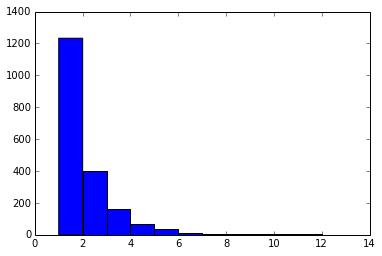

In [20]:
dbcur.execute('''
    SELECT
        SUM(purchase_flg)
    FROM coupon_visit_train_validation
    WHERE purchase_flg = 1
    GROUP BY user_id_hash
    ;
''')
x = []
for row in dbcur.fetchall():
    x.append(int(row[0]))
plt.figure()
plt.hist(x, bins=numpy.arange(1, 15))
plt.show()

In [21]:
dbcur.execute('''
    SELECT
        AVG(t1.same_purchase),
        AVG(t1.same_view),
        AVG(t1.same_purchase / t1.same_view) AS same_rate,
        AVG(t1.diff_purchase),
        AVG(t1.diff_view),
        AVG(t1.diff_purchase / t1.diff_view) AS diff_rate
    FROM (
        SELECT
            t1.user_id_hash,
            SUM(t1.genre_name = t3.genre_name AND t2.purchase_flg = 1) AS same_purchase,
            SUM(t1.genre_name = t3.genre_name) AS same_view,
            SUM(t1.genre_name != t3.genre_name AND t2.purchase_flg = 1) AS diff_purchase,
            SUM(t1.genre_name != t3.genre_name) AS diff_view
        FROM (
            SELECT
                t1.user_id_hash, t1.view_coupon_id_hash, t3.genre_name
            FROM coupon_visit_train_training AS t1
            LEFT JOIN coupon_visit_train_training AS t2 ON t1.user_id_hash = t2.user_id_hash AND t1.i_date < t2.i_date
            LEFT JOIN coupon_list_train AS t3 ON t1.view_coupon_id_hash = t3.coupon_id_hash
            WHERE t1.purchase_flg = 1 AND t2.user_id_hash IS NULL
            GROUP BY t1.user_id_hash
        ) AS t1
        LEFT JOIN coupon_visit_train_validation AS t2 ON t1.user_id_hash = t2.user_id_hash
        LEFT JOIN coupon_list_train AS t3 ON t2.view_coupon_id_hash = t3.coupon_id_hash
        LEFT JOIN (
            SELECT user_id_hash
            FROM coupon_visit_train_validation
            WHERE purchase_flg = 1
            GROUP BY user_id_hash
        ) AS t4 ON t1.user_id_hash = t4.user_id_hash
        WHERE t4.user_id_hash IS NOT NULL
        GROUP BY t1.user_id_hash
    ) AS t1
    ;
''')

data = None
for row in dbcur.fetchall():
    data = row
print 'same_purchase: %.2f, same_view: %.2f, same_rate: %.2f, diff_purchase: %.2f, diff_view: %.2f, diff_rate: %.2f' % (data)

same_purchase: 0.64, same_view: 4.24, same_rate: 0.22, diff_purchase: 0.98, diff_view: 7.09, diff_rate: 0.23


same\_purchase ÷ same\_view = 0.14  
diff\_purchase ÷ diff\_view = 0.12  
ですが、same\_rate < diff\_rateです。  
「ユーザは最後に購買したクーポンと同じジャンルのクーポンを、将来購買する可能性が高い。」
という仮説は必ずしも正しくはないですが，  
上記の結果を踏まえると一部のよく購買するユーザについては、仮説が成立している可能性があります。  
TODO：なんで、逆転するかの説明。

### Excercise
どうやら、私の立てた仮説はあまり良くなさそうですね。(^^ ;  

1. 「過去に購買したクーポンがないユーザは最後に閲覧したクーポンと同じジャンルのクーポンを、将来購買する可能性が高い。」を検証してください。
2. 何かしら仮説を立てて、検証してみてください。    
3. また、仮説検証を通して将来の購買と関連の高い指標(≒feature, 表現)があったら、教えてください。







## Links
- [matplotlib入門](http://bicycle1885.hatenablog.com/entry/2014/02/14/023734)
- [scikit-learn: class and function reference](http://scikit-learn.org/stable/modules/classes.html)
- [computational Statistics in Python](http://people.duke.edu/~ccc14/sta-663/index.html)
- [Deep Learning Tutorials](http://deeplearning.net/tutorial/)

## 謝辞
フィードバックをくれた方ありがとうございます！  
Kaggleやリクルートの方ありがとうございます！